In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
# Read in data into a pandas dataframe and then show the contents of the dataframe
sub_file_path = '/home/levi/data/gnn_project/SEC_Filings_2023q2/sub.txt'
sub_df = pd.read_csv(sub_file_path, sep='\t', header=0, nrows=10)
cols = ['adsh', 'name', 'countryba', 'stprba', 'cityba', 'sic', 'ein', 'form', 'period', 'instance']
sub_df = sub_df[cols]
sub_df.head()


In [23]:
# Company lists
dow_list = ['axp', 'amgn', 'aapl', 'ba', 'cat', 'cvx', 'csco', 'ko', 'dow', 'gs', 'hd', 'hon', 'ibm', 'intc', 'jnj', 'jpm', 'mcd', 'mmm', 'mrk', 'msft', 'nke', 'pg', 'crm', 'trv', 'utx', 'vz', 'v', 'wba', 'wmt', 'dis']
# Create a list of the ticker symbols for the S&P 500 companies
sp500_list = ['a', 'aapl', 'abbv', 'abt', 'acn', 'adbe', 'aig', 'all', 'amgn', 'amzn', 'axp', 'ba', 'bac', 'biib', 'bk', 'bkng', 'blk', 'bmy', 'brk.b', 'bsx', 'cat', 'chtr', 'cl', 'cmcsa', 'cof', 'cop', 'cost', 'crm', 'csco', 'cvx', 'dhr', 'dis', 'dow', 'duke', 'emr', 'exc', 'f', 'fb', 'fdx', 'gd', 'ge', 'gild', 'gm', 'goog', 'googl', 'gs', 'hd', 'hon', 'ibm', 'intc', 'jnj', 'jpm', 'kmi', 'ko', 'lly', 'lmt', 'low', 'ma', 'mcd', 'mdlz', 'met', 'microsoft', 'mmm', 'mo', 'mrk', 'ms', 'msft', 'nflx', 'nke', 'nvda', 'orcl', 'pep', 'pfe', 'pg', 'pm', 'pypl', 'qcom', 'crm', 'sbux', 'slb', 'so', 'spg', 't', 'tgt', 'tmo', 'tpr', 'trv', 'tsla', 'txn', 'unh', 'unp', 'ups', 'usb', 'v', 'vz', 'wba', 'wfc', 'wmt', 'xom']
# Create a list of the ticker symbols for the NASDAQ 100 companies
nasdaq100_list = ['aapl', 'adbe', 'adi', 'adp', 'adsk', 'alxn', 'amat', 'amd', 'amgn', 'amzn', 'asml', 'atvi', 'avgo', 'bidu', 'biib', 'bkng', 'bmrn', 'bngo', 'cdns', 'celg', 'cern', 'chkp', 'chtr', 'cmcsa', 'cost', 'csco', 'csct', 'ctas', 'ctrp', 'ctsh', 'ctxs', 'dltr', 'ea', 'ebay', 'esrx', 'fast', 'fb', 'fisv', 'fox', 'foxa', 'gild', 'goog', 'googl', 'has', 'hsic', 'idxx', 'ilmn', 'incy', 'intc', 'intu', 'isrg', 'jd', 'khc', 'klac', 'lbtya', 'lbtym', 'liberty', 'lrcx', 'mar', 'mat', 'mchp', 'mdlz', 'meli', 'mnst', 'msft', 'mu', 'mxim', 'myl', 'nclh', 'nflx', 'ntap', 'ntes', 'nvda', 'nxpi', 'orly', 'payx', 'pcar', 'pypl', 'qcom', 'regn', 'rost', 'sbux', 'sirius', 'swks', 'symc', 'tmus', 'trip', 'tsco', 'tsem', 'txn', 'ulta', 'vrtx', 'vrsn', 'vrtx', 'wdc', 'wday', 'wltw', 'wynn', 'xlnx', 'xray', 'zm']



In [27]:
# print uppercase version of dow_list
dow_list_upper = [x.upper() for x in dow_list]
print(dow_list_upper)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


In [2]:
import requests
import pprint as pp

In [2]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=EARNINGS&symbol=AAPL&apikey=IMSWKZZ2ILUS0FKX'
r = requests.get(url)
data = r.json()

pp.pprint(data)

{'annualEarnings': [{'fiscalDateEnding': '2023-09-30', 'reportedEPS': '6.12'},
                    {'fiscalDateEnding': '2022-09-30', 'reportedEPS': '6.11'},
                    {'fiscalDateEnding': '2021-09-30', 'reportedEPS': '5.62'},
                    {'fiscalDateEnding': '2020-09-30', 'reportedEPS': '3.27'},
                    {'fiscalDateEnding': '2019-09-30', 'reportedEPS': '2.98'},
                    {'fiscalDateEnding': '2018-09-30', 'reportedEPS': '2.97'},
                    {'fiscalDateEnding': '2017-09-30', 'reportedEPS': '2.3'},
                    {'fiscalDateEnding': '2016-09-30', 'reportedEPS': '2.0675'},
                    {'fiscalDateEnding': '2015-09-30', 'reportedEPS': '2.3'},
                    {'fiscalDateEnding': '2014-09-30', 'reportedEPS': '1.6075'},
                    {'fiscalDateEnding': '2013-09-30', 'reportedEPS': '1.415'},
                    {'fiscalDateEnding': '2012-09-30', 'reportedEPS': '1.5775'},
                    {'fiscalDateEnding': '2011-

In [38]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=OVERVIEW&symbol=CSCO&apikey=IMSWKZZ2ILUS0FKX'
r = requests.get(url)
data = r.json()

pp.pprint(data)

{'200DayMovingAverage': '51.14',
 '50DayMovingAverage': '54.38',
 '52WeekHigh': '57.77',
 '52WeekLow': '42.58',
 'Address': '170 WEST TASMAN DR, SAN JOSE, CA, US',
 'AnalystTargetPrice': '55.39',
 'AssetType': 'Common Stock',
 'Beta': '0.963',
 'BookValue': '10.91',
 'CIK': '858877',
 'Country': 'USA',
 'Currency': 'USD',
 'Description': 'Cisco Systems, Inc. is an American multinational technology '
                'conglomerate headquartered in San Jose, California, in the '
                'center of Silicon Valley. Cisco develops, manufactures and '
                'sells networking hardware, software, telecommunications '
                'equipment and other high-technology services and products. '
                'Through its numerous acquired subsidiaries, such as OpenDNS, '
                'Webex, Jabber and Jasper, Cisco specializes in specific tech '
                'markets, such as the Internet of Things (IoT), domain '
                'security and energy management. On Jan

In [3]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=MSFT&apikey=IMSWKZZ2ILUS0FKX'
r = requests.get(url)
data = r.json()

pp.pprint(data)

{'annualReports': [{'comprehensiveIncomeNetOfTax': '70696000000',
                    'costOfRevenue': '100049000000',
                    'costofGoodsAndServicesSold': '65863000000',
                    'depreciation': '11000000000',
                    'depreciationAndAmortization': '3852000000',
                    'ebit': '91279000000',
                    'ebitda': '95131000000',
                    'fiscalDateEnding': '2023-06-30',
                    'grossProfit': '146052000000',
                    'incomeBeforeTax': '89311000000',
                    'incomeTaxExpense': '16950000000',
                    'interestAndDebtExpense': '1968000000',
                    'interestExpense': '1968000000',
                    'interestIncome': '1041000000',
                    'investmentIncomeNet': '2994000000',
                    'netIncome': '72361000000',
                    'netIncomeFromContinuingOperations': '72361000000',
                    'netInterestIncome': '-1968000000',


In [40]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=CSCO&apikey=IMSWKZZ2ILUS0FKX'
r = requests.get(url)
data = r.json()

pp.pprint(data)

{'annualReports': [{'accumulatedDepreciationAmortizationPPE': '7973000000',
                    'capitalLeaseObligations': 'None',
                    'cashAndCashEquivalentsAtCarryingValue': '10123000000',
                    'cashAndShortTermInvestments': '26146000000',
                    'commonStock': '44289000000',
                    'commonStockSharesOutstanding': '4066000000',
                    'currentAccountsPayable': '2313000000',
                    'currentDebt': '1733000000',
                    'currentLongTermDebt': '1733000000',
                    'currentNetReceivables': '9252000000',
                    'deferredRevenue': '51150000000',
                    'fiscalDateEnding': '2023-07-29',
                    'goodwill': '38535000000',
                    'intangibleAssets': '40353000000',
                    'intangibleAssetsExcludingGoodwill': '1818000000',
                    'inventory': '3644000000',
                    'investments': '24229000000',
        

In [41]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=CASH_FLOW&symbol=CSCO&apikey=IMSWKZZ2ILUS0FKX'
r = requests.get(url)
data = r.json()

pp.pprint(data)

{'annualReports': [{'capitalExpenditures': '849000000',
                    'cashflowFromFinancing': '-11626000000',
                    'cashflowFromInvestment': '-5107000000',
                    'changeInCashAndCashEquivalents': 'None',
                    'changeInExchangeRate': 'None',
                    'changeInInventory': '1069000000',
                    'changeInOperatingAssets': '-772000000',
                    'changeInOperatingLiabilities': '4270000000',
                    'changeInReceivables': '-1836000000',
                    'depreciationDepletionAndAmortization': '700000000',
                    'dividendPayout': '6302000000',
                    'dividendPayoutCommonStock': '6302000000',
                    'dividendPayoutPreferredStock': 'None',
                    'fiscalDateEnding': '2023-07-29',
                    'netIncome': '12613000000',
                    'operatingCashflow': '19886000000',
                    'paymentsForOperatingActivities': '1077000

In [3]:
import requests
import pprint as pp
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol=AAPL&apikey=IMSWKZZ2ILUS0FKX'
r = requests.get(url)
data = r.json()

pp.pprint(data)

{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and '
                                 'Volumes',
               '2. Symbol': 'AAPL',
               '3. Last Refreshed': '2023-11-24',
               '4. Time Zone': 'US/Eastern'},
 'Monthly Time Series': {'1999-12-31': {'1. open': '101.0000',
                                        '2. high': '118.0000',
                                        '3. low': '91.0600',
                                        '4. close': '102.8100',
                                        '5. volume': '84091200'},
                         '2000-01-31': {'1. open': '104.8700',
                                        '2. high': '121.5000',
                                        '3. low': '86.5000',
                                        '4. close': '103.7500',
                                        '5. volume': '112099800'},
                         '2000-02-29': {'1. open': '104.0000',
                                        '2. hi

In [48]:
import datetime
datestr = '2023-01-31'
# For the date string get the date of the previous month
date = datetime.datetime.strptime(datestr, '%Y-%m-%d')
# Get the date of one month before the date above
date = date - datetime.timedelta(days=31)
# Convert the date back to a string
datestr = date.strftime('%Y-%m')
datestr

#data['Monthly Adjusted Time Series']['2023-01-31']

'2022-12'

In [ ]:
year = 2023
month = 9
time_series = data['Monthly Adjusted Time Series']
for i in range(3):
    price_key = [date for date in time_series.keys() if date[:7] == f'{year}-{month-i:02d}'][0]
    close_price = time_series[price_key]['5. adjusted close']
    print(close_price)
    



In [ ]:
num_file_path = '/home/levi/data/gnn_project/SEC_Filings_2023q2/num.txt'
num_df = pd.read_csv(num_file_path, sep='\t', header=0, nrows=10)
cols = ['adsh', 'tag', 'ddate', 'uom', 'value']
num_df = num_df[cols]
num_df.head()


In [ ]:
tag_file_path = '/home/levi/data/gnn_project/SEC_Filings_2023q2/tag.txt'
tag_df = pd.read_csv(tag_file_path, sep='\t', header=0, nrows=100)
#cols = ['adsh', 'tag', 'ddate', 'uom', 'value']
#tag_df = tag_df[cols]
tag_df.head(50)

In [ ]:
len(tag_df)

In [ ]:
pre_file_path = '/home/levi/data/gnn_project/SEC_Filings_2023q2/pre.txt'
pre_df = pd.read_csv(pre_file_path, sep='\t', header=0, nrows=10)
#cols = ['adsh', 'tag', 'ddate', 'uom', 'value']
#tag_df = tag_df[cols]
pre_df.head(10)

In [ ]:
df.columns

In [32]:


# Fake data feature:
# quarter of the year [range(4)] (time of year dependency)
# market capitalization $B (company size dependency)
# industry [range(11)] of the SP500 sectors (type of company dependency)
# PE ratio (expected growth dependency)
# Analyst rating [range(3)] sell=0, hold=1, buy=2
fake_features = [
    (np.random.randint(0, 4),
      np.random.randint(0, 100), 
      np.random.randint(0, 11), 
      np.random.randint(0, 100), 
      np.random.randint(0, 3)) for _ in range(10)
]


In [33]:
fake_features

[(2, 35, 1, 88, 1),
 (3, 37, 3, 56, 0),
 (2, 89, 5, 18, 2),
 (0, 10, 5, 71, 2),
 (0, 73, 0, 10, 1),
 (3, 31, 2, 90, 2),
 (2, 80, 2, 65, 0),
 (0, 51, 10, 15, 1),
 (2, 57, 9, 7, 0),
 (3, 10, 8, 91, 2)]

In [ ]:
import torch
from torch_geometric.data import Data

# Nodes (companies) and their features
# x = torch.tensor([feature_vector_for_company_1, feature_vector_for_company_2, ...], dtype=torch.float)
x = torch.tensor(fake_features, dtype=torch.float)

# Edge connections 
# edge_index = torch.tensor([
#     [source_node_1, source_node_2, ...],
#     [target_node_1, target_node_2, ...],
# ], dtype=torch.long)
edge_index = torch.tensor([
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [1, 0, 3, 2, 5, 4, 7, 6, 9, 8],
], dtype=torch.long)

# Labels for nodes (whether stock price will go up (1) or down (0))
#y = torch.tensor([label_for_company_1, label_for_company_2, ...], dtype=torch.float)
y = torch.tensor([
    np.random.randint(0, 2) for _ in range(10)
], dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)


In [ ]:
# Inspect the data shape
print(f"Node data shape: {x.shape}")
print(f"Edge data shape: {edge_index.shape}")
print(f"Label data shape: {y.shape}")   
data.num_classes = 1
data.num_nodes = 10


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class StockGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 3)  # 5 -> 3
        self.conv2 = GCNConv(3, data.num_classes) # 3 -> 1

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(10):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

In [2]:
import h5py
import numpy as np



<KeysViewHDF5 ['edges', 'nodes', 'targets']>
<KeysViewHDF5 ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']>


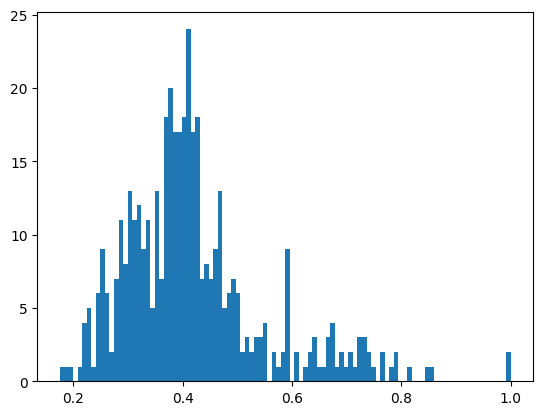

IndexError: Index (11) out of range for (0-10)

In [59]:
import matplotlib.pyplot as plt
EBEMP_data_path = 'data/EBEMP_data_dow_11qtrs.hdf5'
f = h5py.File(EBEMP_data_path, 'r')
print(f.keys())
print(f['nodes'].keys())
# plot a histogram of the edge weights
weights_list = [f['edges/'+i][0][0] for i in f['edges'].keys()]
plt.hist(weights_list, bins=100)
plt.show()

print(f['nodes/AAPL'][11,])
f.close()

<KeysViewHDF5 ['edges', 'nodes', 'targets']>
<KeysViewHDF5 ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO']>
[[1.89970001e+02 9.28984064e+08 1.10000000e+01 2.02300000e+03]
 [1.70550400e+02 1.17284582e+09 1.00000000e+01 2.02300000e+03]
 [1.70989807e+02 1.33787379e+09 9.00000000e+00 2.02300000e+03]
 [1.87628403e+02 1.32381734e+09 8.00000000e+00 2.02300000e+03]
 [1.95932907e+02 9.96368640e+08 7.00000000e+00 2.02300000e+03]
 [1.93459396e+02 1.29786342e+09 6.00000000e+00 2.02300000e+03]
 [1.76783401e+02 1.27505254e+09 5.00000000e+00 2.02300000e+03]
 [1.68998306e+02 9.67580736e+08 4.00000000e+00 2.02300000e+03]
 [1.64237503e+02 1.52046131e+09 3.00000000e+00 2.02300000e+03]
 [1.46817795e+02 1.30729446e+09 2.00000000e+00 2.02300000e+03]
 [1.43491806e+02 1.44365274e+09 1.00000000e+00 2.02300000e+03]
 [1.29211197e+02 1.67573133e+09 1.20000000e+01 2.02200000e+03]]


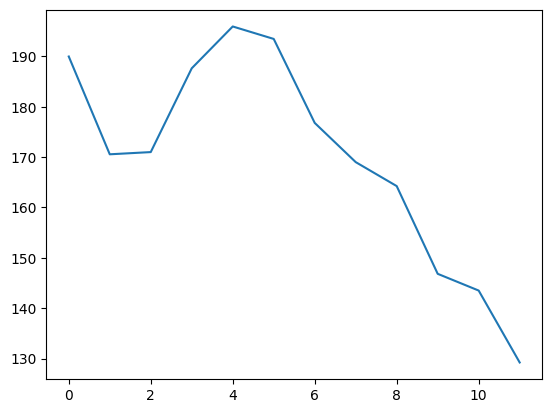

In [4]:
import h5py
import matplotlib.pyplot as plt
ATGCN_data_path = 'data/A3TGCN_PriceData_12months_20231126.hdf5'
f = h5py.File(ATGCN_data_path, 'r')
print(f.keys())
print(f['nodes'].keys())
print(f['nodes/AAPL'][:])
plt.plot(f['nodes/AAPL'][:,0])
f.close()